In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt

## **Transformation** dans un autre domaine

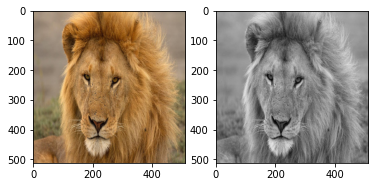

In [2]:
# Chargement de l'image
filename = './figures/06.png'
IMAGE_bgr = cv2.imread(filename)
IMAGE_rgb = cv2.cvtColor(IMAGE_bgr, cv2.COLOR_BGR2RGB)
IMAGE_nb = cv2.cvtColor(IMAGE_rgb, cv2.COLOR_RGB2GRAY)
[H,W] = IMAGE_nb.shape
plt.subplot(121)
plt.imshow(IMAGE_rgb)
plt.subplot(122)
plt.imshow(IMAGE_nb, cmap='gray')
plt.show()

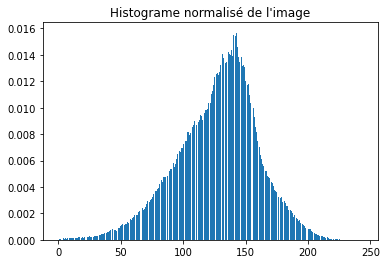

In [3]:
hist_IMAGE_nb, bin_edges_IMAGE_nb = np.histogram(IMAGE_nb, bins=255)
bin_edges_IMAGE_nb = bin_edges_IMAGE_nb[:-1:]
hist_IMAGE_nb_normalise = hist_IMAGE_nb / (H*W) 
plt.bar(bin_edges_IMAGE_nb, hist_IMAGE_nb_normalise)
plt.title('Histograme normalisé de l\'image')
plt.show()
# plt.plot(bin_edges_IMAGE_nb, hist_IMAGE_nb)


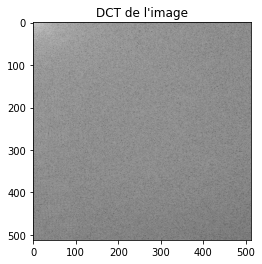

In [4]:
# Transformation - DCT - Dicrete Cosinus Transform
IMAGE_DCT = cv2.dct(IMAGE_nb.astype(float))

plt.imshow(np.log(np.abs(IMAGE_DCT)), 'gray')
plt.title('DCT de l\'image' )
plt.show()

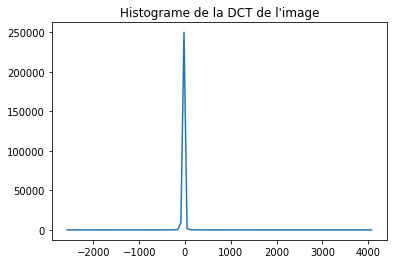

In [5]:
# hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT, bins=1000)

IMAGE_DCT_sansMin = np.copy(IMAGE_DCT)
IMAGE_DCT_sansMin[0][0] = 0
hist_IMAGE_DCT, bin_edges_IMAGE_DCT = np.histogram(IMAGE_DCT_sansMin, bins=100)

bin_edges_IMAGE_DCT = bin_edges_IMAGE_DCT[:-1:]
plt.plot(bin_edges_IMAGE_DCT, hist_IMAGE_DCT)
plt.title('Histograme de la DCT de l\'image')
plt.show()

## **Codage** et **quantification** des coefficients

In [6]:
# Decoupage de l'image
listImages88 = list()
I,J = 0,0
for i in range(W//8):
    for j in range(H//8):
        # imagette = IMAGE_nb[J:J+8, I:I+8]
        imagette = IMAGE_nb[i*8:(i+1)*8 , j*8:(j+1)*8]
        listImages88.append(imagette)
        J+=j*8
    I+=i*8


In [7]:
# Calcul DCT par bloc 
listImages88DCT = list()
for imagette in listImages88:
    foo = cv2.dct(imagette.astype(float))
    listImages88DCT.append( foo )
    

### **Quantification**

In [23]:
Z = [[16, 11, 10, 16, 24,  40,  51,  61],
     [12, 12, 14, 19, 26,  58,  60,  55],
     [14, 13, 16, 24, 40,  57,  69,  56],
     [14, 17, 22, 29, 51,  87,  80,  62],
     [18, 22, 37, 56, 68,  109, 103, 77],
     [24, 35, 55, 64, 81,  104, 113, 92],
     [49, 64, 78, 87, 103, 121, 120, 101],
     [72, 92, 95, 98, 112, 100, 103, 99]]
Z = np.array(Z)
T_hat = list()
T_hat_posNonNul = list()

for T in listImages88DCT:
     tmp = (T/Z).round().astype(int)
     T_hat.append( tmp )
     position = np.where(np.abs(tmp)>0,1,0)
     T_hat_posNonNul.append(position)



### **Codage**

In [16]:
def zigzag(a):
    # returnList = list()
    returnList = np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])
    return returnList

In [37]:
# Parcours en zigzag de chaque DFT 8x8
CODE_values = list()
CODE_position = list()
for (imagette,position) in zip(T_hat,T_hat_posNonNul):
    codeBloc = zigzag(imagette)  
    codePosition = zigzag(position) 
    codePosition2 = ''.join(map(str, codePosition))
    # print(codePosition2)
    CODE_values.append(codeBloc) 
    CODE_position.append(codePosition2)


In [38]:
def run_length_encode(input_str):
    run_length_encoded_string = []
    current_run_length = 1
    # Perform a run length encoding of input_str
    for i in range(1, len(input_str)):
        current_char = input_str[i]
        previous_char = input_str[i-1]
        if current_char != previous_char or current_run_length == 9:
            run_length_encoded_string.append(str(current_run_length))
            run_length_encoded_string.append(previous_char)
            current_run_length = 0
        current_run_length += 1
    # Handle any remaining character
    run_length_encoded_string.append(str(current_run_length))
    run_length_encoded_string.append(input_str[len(input_str)-1])
    return "".join(run_length_encoded_string)

In [40]:
# codage par plage pour enchainer les positions non nulles 




for position in CODE_position:
    codageParPlage = run_length_encode(position)
    print(position)
    print(codageParPlage)
    
        


3190909090909070
3190909090909070
11101190909090909070
2190909090909080
2190909090909080
2190909090909080
11101190909090909070
11101190909090909070
3190909090909070
3190909090909070
11101190909090909070
11101190909090909070
3190909090909070
3190909090909070
2190909090909080
21201190909090909050
3130111021101170119090909080
611031201160119090909080
2110411021102150219090909080
51202110116011909090909010
31102110311031201110119090909090
111031204170119090909090
4110111041901130219090909020
3110112021301140219090909090
611021101110213011909090909010
21201130113021909090909050
21107110313011909090909010
3110611011102190301190909090
91512011101110116021101190909060
91211031201110112011601190909070
3110215021102130119090909080
31104160114011701190909090
311081402160119090909030
311011102150112011909090909020
111011103120115011909090909030
3110316011909090909050
41101120117011909090909020
3110414011909090909060
41103110116021909090909010
211011202130114011101150219090909020
211041102190909090

## **Décodage** et **décompression** de l'image